<a href="https://colab.research.google.com/github/cengizmehmet/PowerEstimationNetworks/blob/master/notebooks/continual_learning_unseen_power_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# ============================================================
# Dependencies
# ============================================================

# --- Standard library & typing ---
from dataclasses import dataclass, field
from typing import Any, Dict, Iterable, Optional, Union
import random
from collections import Counter

# --- Core scientific stack ---
import numpy as np
import pandas as pd

# --- Visualisation (diagnostics & analysis) ---
import matplotlib.pyplot as plt

# --- Machine learning / deep learning ---
import tensorflow as tf
from tensorflow.keras import (
    Input,
    Model,
    backend as K,
    layers,
    metrics,
    optimizers,
    regularizers,
)
from tensorflow.keras.activations import softplus
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

# --- Classical ML utilities ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    Normalizer,
    MaxAbsScaler,
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_pinball_loss,
)

In [58]:
# ============================================================
# Reproducibility
# ============================================================
# Set random seeds for Python, NumPy, and TensorFlow to ensure
# deterministic behaviour across runs (as far as supported).

SEED = 42  # arbitrary but fixed for reproducibility

def set_global_seed(seed: int) -> None:
    """Set random seeds for reproducible experiments."""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(SEED)

In [59]:
class DataProcessor:
    """
    Lightweight utility for loading tabular data, fitting/assigning a Keras tokenizer,
    and producing simple sequence-length statistics + padded tokenized sequences.

    Notes:
        - This class intentionally stores both `data` and `targets` as loaded from CSV.
        - Tokenizer-related metadata is tracked in `self.stats`.
    """

    def __init__(self, data_path: str, target_column: str):
        self.data = pd.read_csv(data_path)
        self.targets = self.data[target_column]
        self.tokenizer = None
        self.max_seq_len = None
        self.stats: Dict[str, Any] = {}

    def initialize_tokenizer(self, data_column: str) -> None:
        """Create and fit a new tokenizer on the specified text column."""
        self.tokenizer = Tokenizer()
        sentences = self.data[data_column].to_list()
        self.tokenizer.fit_on_texts(sentences)

        self.stats["num_words"] = len(self.tokenizer.word_index) + 1
        self.stats["embedding_dim"] = min(512, self.stats["num_words"])

    def set_tokenizer(self, tokenizer: Tokenizer, max_seq_len: int, embedding_dim: int) -> None:
        """
        Assign an existing tokenizer and set tokenizer-dependent stats.

        Args:
            tokenizer: A pre-fit Keras Tokenizer.
            max_seq_len: Kept for API compatibility with your notebook (intentionally not stored/used here).
            embedding_dim: Desired embedding dimensionality (explicitly set by caller).
        """
        self.tokenizer = tokenizer
        self.stats["num_words"] = len(self.tokenizer.word_index) + 1
        self.stats["embedding_dim"] = embedding_dim

    def length_stats(self, sequences: pd.Series) -> None:
        """
        Compute sequence length statistics (tokenized lengths) from raw text.

        Stores results into:
            stats['max_length'], stats['min_length'], stats['avg_length'], stats['percentile_95']
        """
        if self.tokenizer is None:
            raise ValueError("Tokenizer is not initialized. Call initialize_tokenizer() or set_tokenizer() first.")

        sentences = sequences.tolist()
        tokenized_sentences = self.tokenizer.texts_to_sequences(sentences)

        sentence_lengths = [len(s) for s in tokenized_sentences if len(s) > 0]
        if not sentence_lengths:
            # Preserve mechanics: previously this would error on np.max/min.
            # Here we raise a clearer message while still failing fast.
            raise ValueError("All sequences are empty after tokenization; cannot compute length statistics.")

        self.stats["max_length"] = np.max(sentence_lengths)
        self.stats["min_length"] = np.min(sentence_lengths)
        self.stats["avg_length"] = np.mean(sentence_lengths)
        self.stats["percentile_95"] = np.percentile(sentence_lengths, 95)

    def resolve_max_seq_len(self, max_seq_len: Union[int, str]) -> int:
        """
        Resolve max sequence length either from an explicit integer or a stats key.

        Accepts:
            - int: used directly
            - str: one of {'min_length', 'max_length', 'avg_length', 'percentile_95'}
        """
        if isinstance(max_seq_len, int):
            return max_seq_len
        if max_seq_len in self.stats:
            return int(self.stats[max_seq_len])

        raise ValueError(
            "Invalid max_seq_len value. Choose from "
            "'min_length', 'max_length', 'avg_length', 'percentile_95', or an integer."
        )

    def pad_tokenize_sequences(
        self,
        tokenizer: Tokenizer,
        sequences: Iterable[str],
        max_seq_len: int,
    ) -> np.ndarray:
        """Tokenize sequences and pad them to `max_seq_len` (post-padding)."""
        tokenized_sequences = tokenizer.texts_to_sequences(sequences)
        padded_sequences = pad_sequences(tokenized_sequences, maxlen=max_seq_len, padding="post")
        return padded_sequences

    def print_stats(self, stats: Dict[str, Any]) -> None:
        """Pretty-print common stats if present."""
        key_to_label = {
            "num_words": "Vocabulary size",
            "embedding_dim": "Embedding dimension",
            "max_length": "Max length",
            "min_length": "Min length",
            "avg_length": "Avg length",
            "percentile_95": "Percentile 95",
        }

        for key, label in key_to_label.items():
            if key in stats:
                print(f"{label}: {stats[key]}")

In [60]:
# ============================================================
# Data paths (user-configurable)
# ============================================================
# NOTE:
# These paths can be freely changed by the user depending on where
# the dataset is stored (e.g., local machine, Google Drive, or remote URL).
#
# Official raw GitHub versions (optional alternatives):
#   - Training: https://raw.githubusercontent.com/cengizmehmet/PowerEstimationNetworks/refs/heads/master/data/splits/training.csv
#   - Test:     https://raw.githubusercontent.com/cengizmehmet/PowerEstimationNetworks/refs/heads/master/data/splits/test.csv
#   - Unknown:  https://raw.githubusercontent.com/cengizmehmet/PowerEstimationNetworks/refs/heads/master/data/splits/unknown.csv

training_data_path = "https://raw.githubusercontent.com/cengizmehmet/PowerEstimationNetworks/refs/heads/master/data/splits/training.csv"
test_data_path     = "https://raw.githubusercontent.com/cengizmehmet/PowerEstimationNetworks/refs/heads/master/data/splits/test.csv"
unknown_data_path  = "https://raw.githubusercontent.com/cengizmehmet/PowerEstimationNetworks/refs/heads/master/data/splits/unknown.csv"

DATA_COLUMN = "Model"
TARGET_COLUMN = "Avg_Power_Simpson"

In [61]:
# ============================================================
# Training data processing
# ============================================================
data_processor = DataProcessor(training_data_path, TARGET_COLUMN)
data_processor.initialize_tokenizer(DATA_COLUMN)
data_processor.length_stats(data_processor.data[DATA_COLUMN])
data_processor.print_stats(data_processor.stats)

data_processor.max_seq_len = data_processor.resolve_max_seq_len("avg_length")

data_sequences = np.array(
    data_processor.pad_tokenize_sequences(
        tokenizer=data_processor.tokenizer,
        sequences=data_processor.data[DATA_COLUMN],
        max_seq_len=data_processor.max_seq_len,
    )
)

Vocabulary size: 143
Embedding dimension: 143
Max length: 6552
Min length: 24
Avg length: 1001.789013732834
Percentile 95: 6552.0


In [62]:
# ============================================================
# Test data processing (shared tokenizer)
# ============================================================
test_processor = DataProcessor(test_data_path, TARGET_COLUMN)

test_sequences = np.array(
    test_processor.pad_tokenize_sequences(
        tokenizer=data_processor.tokenizer,
        sequences=test_processor.data[DATA_COLUMN],
        max_seq_len=data_processor.max_seq_len,
    )
)

In [63]:
# ============================================================
# Unknown data processing (extended vocabulary)
# ============================================================
unknown_processor = DataProcessor(unknown_data_path, TARGET_COLUMN)

temp_tokenizer = Tokenizer()
extended_data = pd.concat([data_processor.data, unknown_processor.data])
temp_tokenizer.fit_on_texts(extended_data[DATA_COLUMN])

unknown_processor.set_tokenizer(
    temp_tokenizer,
    data_processor.max_seq_len,
    data_processor.stats["embedding_dim"],
)

unknown_processor.length_stats(extended_data[DATA_COLUMN])
unknown_processor.print_stats(unknown_processor.stats)

unknown_processor.max_seq_len = data_processor.max_seq_len

unknown_sequences = np.array(
    unknown_processor.pad_tokenize_sequences(
        tokenizer=unknown_processor.tokenizer,
        sequences=unknown_processor.data[DATA_COLUMN],
        max_seq_len=unknown_processor.max_seq_len,
    )
)

Vocabulary size: 151
Embedding dimension: 143
Max length: 6552
Min length: 24
Avg length: 988.6046798029556
Percentile 95: 6552.0


In [64]:
# ============================================================
# Dataset merging & splitting
# ============================================================
merged_sequences = np.concatenate((test_sequences, unknown_sequences), axis=0)
merged_targets = pd.concat([test_processor.targets, unknown_processor.targets])

train_X, val_X, train_y, val_y = train_test_split(
    data_sequences,
    data_processor.targets,
    test_size=0.2,
    random_state=SEED,
)

In [65]:
# ============================================================
# Target scaling
# ============================================================
scaler_y = MinMaxScaler()
scaler_unknown_y = MinMaxScaler()
scaler_merged_y = MinMaxScaler()

scaled_train_y = scaler_y.fit_transform(train_y.values.reshape(-1, 1))
scaled_val_y   = scaler_y.transform(val_y.values.reshape(-1, 1))
scaled_test_y  = scaler_y.transform(test_processor.targets.values.reshape(-1, 1))

scaled_unknown_y = scaler_unknown_y.fit_transform(
    unknown_processor.targets.values.reshape(-1, 1)
)
scaled_merged_y = scaler_merged_y.fit_transform(
    merged_targets.values.reshape(-1, 1)
)

In [66]:
def plot_learning_curve(history) -> None:
    """
    Plot training (and optionally validation) loss from a Keras History object.
    """
    if history is None:
        raise ValueError("Cannot plot learning curve: `history` is None (model not trained?).")

    if not hasattr(history, "history") or "loss" not in history.history:
        raise ValueError("Cannot plot learning curve: invalid History object (missing `history['loss']`).")

    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"], label="Training Loss")

    val_loss = history.history.get("val_loss")
    if val_loss is not None:
        plt.plot(val_loss, label="Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

In [67]:
def plot_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Scatter plot of actual vs. predicted values with an ideal y=x reference line.
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color="blue", label="Predicted")
    plt.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        color="red",
        linestyle="--",
        label="Ideal Line",
    )
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs. Predicted Values")
    plt.legend()
    plt.show()

In [68]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Compute standard regression metrics (MSE, MAE, R2, mean pinball loss).

    Returns:
        (mse, mae, r2, mpl) or (None, None, None, None) if y_pred contains NaNs.
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if np.isnan(y_pred).any():
        print("Evaluation metrics cannot be calculated because y_pred contains NaN values.")
        return None, None, None, None

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mpl = mean_pinball_loss(y_true, y_pred)

    return mse, mae, r2, mpl

In [69]:
def predict_data(model, data: np.ndarray, actual: np.ndarray, scaler) -> None:
    """
    Run model prediction, inverse-transform outputs, print metrics, and plot predictions.
    """
    predictions = model.predict(data)
    unscaled_predictions = scaler.inverse_transform(predictions)

    mse, mae, r2, mpl = evaluate_model(actual, unscaled_predictions)
    print(f"MSE: {mse}\nMAE: {mae}\nR2: {r2}\nMPL: {mpl}")

    plot_predictions(actual, unscaled_predictions)

In [70]:
# ============================================================
# Shared modules (re-used across model components)
# ============================================================
# Notes
# -----
# The number of shared RNN layers is a design choice. In this work, three
# stacked RNN-based layers are used as a practical trade-off between model
# capacity and training stability. While additional recurrent layers can be
# introduced if required, empirical observations suggest that using more than
# three recurrent layers (GRUs, LSTMs, etc.) often yields diminishing returns
# and may negatively affect optimisation and generalisation, particularly when
# the architecture design process is manual.

embedding_dim = int(data_processor.stats["embedding_dim"])

shared_module_1 = layers.SimpleRNN(embedding_dim, return_sequences=True, name="shared_module_1")
shared_module_2 = layers.SimpleRNN(embedding_dim, return_sequences=True, name="shared_module_2")
shared_module_3 = layers.SimpleRNN(embedding_dim, return_sequences=True, name="shared_module_3")

out_act_fn = "linear"

In [71]:
# ============================================================
# Progressive Neural Network
# Block 1
# ============================================================
# NOTE:
# This study employs a progressive neural network paradigm.
# The number of blocks (columns) and their configurations may vary
# depending on the experimental setup. Block 1 serves as the
# initial baseline column and is trained independently.
#
# Optional layers (BatchNorm / Dropout) are intentionally commented
# out to preserve the baseline architecture and enable controlled
# ablation studies when activated.

loss_B1 = "mse"
optimizer_B1 = optimizers.Adam(learning_rate=0.001)

metrics_list_B1 = [
    metrics.MeanAbsoluteError(),
    metrics.MeanAbsolutePercentageError(),
    metrics.RootMeanSquaredError(),
    metrics.MeanSquaredLogarithmicError(),
]

In [72]:
# ============================================================
# Input & Embedding
# ============================================================
embedding_layer_B1 = layers.Embedding(
    input_dim=data_processor.stats["num_words"],
    output_dim=data_processor.stats["embedding_dim"],
    trainable=True,
    mask_zero=True,
    name="embedding_layer_B1",
)

inp_seq_B1 = layers.Input(
    shape=(data_processor.max_seq_len,),
    name="input_sequence_B1",
)

x_B1 = embedding_layer_B1(inp_seq_B1)

In [73]:
# ============================================================
# Recurrent feature extraction (shared modules)
# ============================================================
x_B1 = shared_module_1(x_B1)

# --- Optional regularisation (disabled for baseline) ---
# x_B1 = layers.BatchNormalization(name="batch_norm_B1_1")(x_B1)
# x_B1 = layers.Dropout(0.2, name="dropout_B1_1")(x_B1)

x_B1 = shared_module_2(x_B1)

# --- Optional regularisation (disabled for baseline) ---
# x_B1 = layers.BatchNormalization(name="batch_norm_B1_2")(x_B1)
# x_B1 = layers.Dropout(0.2, name="dropout_B1_2")(x_B1)

x_B1 = shared_module_3(x_B1)

# --- Optional regularisation (disabled for baseline) ---
# x_B1 = layers.BatchNormalization(name="batch_norm_B1_3")(x_B1)
# x_B1 = layers.Dropout(0.2, name="dropout_B1_3")(x_B1)

In [74]:
# ============================================================
# Aggregation & prediction head
# ============================================================
x_B1 = layers.GlobalAveragePooling1D(
    name="global_average_pooling_B1"
)(x_B1)

x_B1 = layers.Dense(
    int(data_processor.stats["embedding_dim"]),
    activation="relu",
    name="dense_B1_1",
)(x_B1)

x_B1 = layers.Dense(
    int(data_processor.stats["embedding_dim"]),
    activation="relu",
    name="dense_B1_2",
)(x_B1)

out_B1 = layers.Dense(
    1,
    activation=out_act_fn,
    name="output_B1",
)(x_B1)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - loss: 0.1214 - mean_absolute_error: 0.2597 - mean_absolute_percentage_error: 27270.3086 - mean_squared_logarithmic_error: 0.0594 - root_mean_squared_error: 0.3457 - val_loss: 0.0285 - val_mean_absolute_error: 0.1360 - val_mean_absolute_percentage_error: 13773.2021 - val_mean_squared_logarithmic_error: 0.0177 - val_root_mean_squared_error: 0.1689
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0222 - mean_absolute_error: 0.1138 - mean_absolute_percentage_error: 40983.9375 - mean_squared_logarithmic_error: 0.0136 - root_mean_squared_error: 0.1490 - val_loss: 0.0210 - val_mean_absolute_error: 0.0934 - val_mean_absolute_percentage_error: 3696.0249 - val_mean_squared_logarithmic_error: 0.0107 - val_root_mean_squared_error: 0.1450
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - loss: 0.0150 - mean_absolute_error: 0.0865 - mean_absolute_percentage_error: 24778.1680 - mean_squared_logarithmic_error: 0.0081 - root_mean_squared_

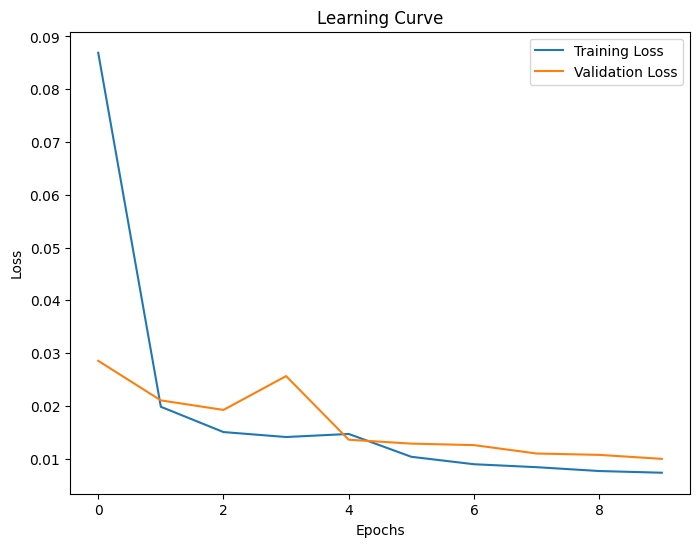

In [75]:
# ============================================================
# Model compilation & training
# ============================================================
model_B1 = Model(
    inputs=inp_seq_B1,
    outputs=out_B1,
    name="model_B1",
)

model_B1.compile(
    loss=loss_B1,
    optimizer=optimizer_B1,
    metrics=metrics_list_B1,
)

history_B1 = model_B1.fit(
    train_X,
    scaled_train_y,
    epochs=10,
    batch_size=64,
    validation_data=(val_X, scaled_val_y),
)

plot_learning_curve(history_B1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 783ms/step
MSE: 6556156.428511122
MAE: 1446.187707665631
R2: 0.8301637999205826
MPL: 723.0938538328155


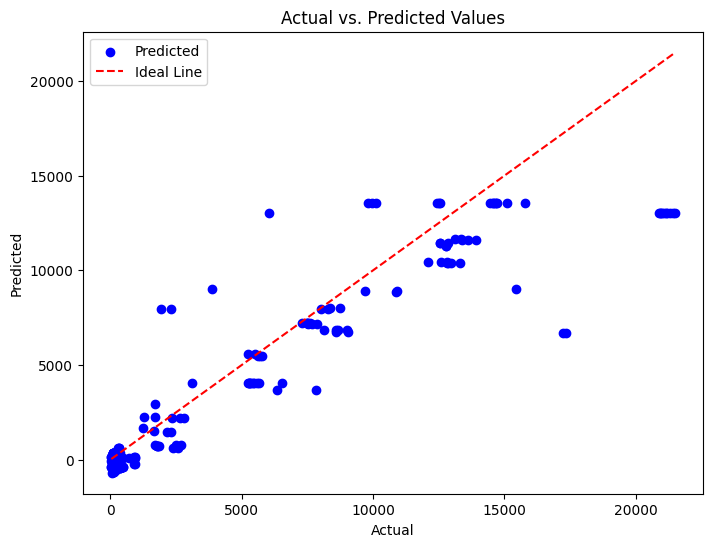

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MSE: 308036592.524811
MAE: 11000.088432985685
R2: -0.7342148101446218
MPL: 5500.044216492843


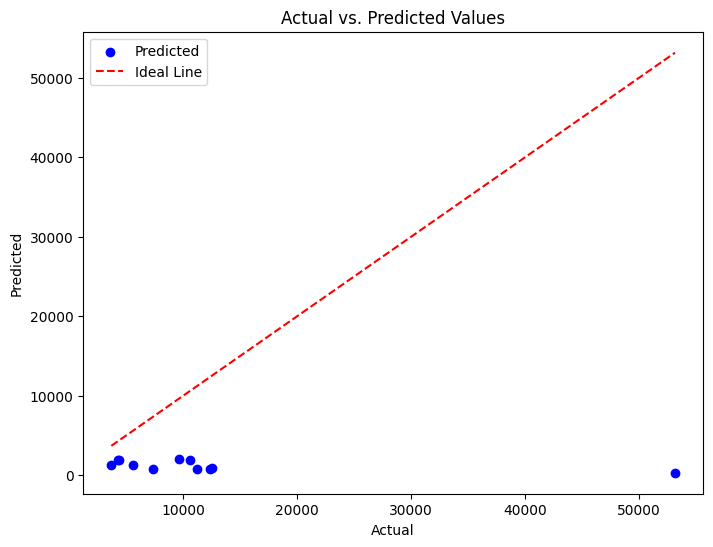

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step
MSE: 55896889.08617631
MAE: 4528.211771229186
R2: -0.1563197418428266
MPL: 2264.105885614593


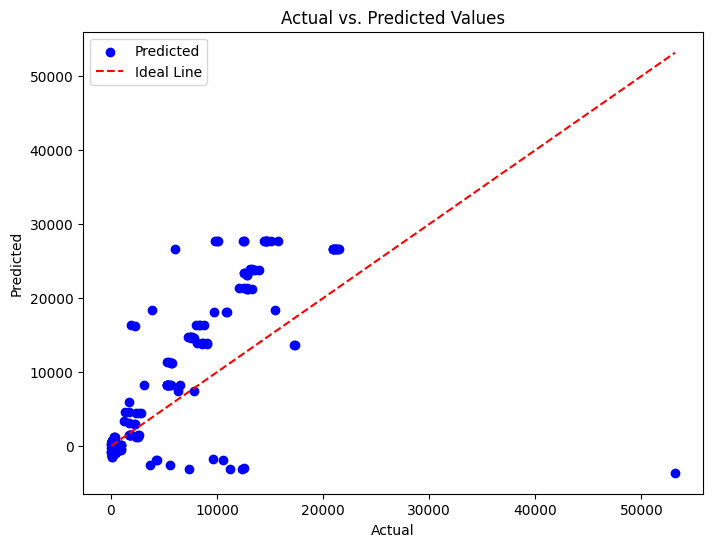

In [82]:
# ============================================================
# Evaluation (Block 1)
# NOTE:
# Block 1's embedding layer was built using the training tokenizer
# (`data_processor.tokenizer`). Therefore, any inference inputs must
# be tokenized with the same tokenizer to avoid out-of-vocabulary
# indices exceeding the embedding `input_dim`.
# ============================================================

# --- Test (already tokenized with training tokenizer) ---
predict_data(model_B1, test_sequences, test_processor.targets, scaler_y)

# --- Unknown (re-tokenize with Block 1 tokenizer) ---
unknown_sequences_B1 = np.array(
    unknown_processor.pad_tokenize_sequences(
        tokenizer=data_processor.tokenizer,
        sequences=unknown_processor.data[DATA_COLUMN],
        max_seq_len=data_processor.max_seq_len,
    )
)
predict_data(model_B1, unknown_sequences_B1, unknown_processor.targets, scaler_unknown_y)

# --- Merged (must use the Block 1-compatible unknown sequences) ---
merged_sequences_B1 = np.concatenate((test_sequences, unknown_sequences_B1), axis=0)
predict_data(model_B1, merged_sequences_B1, merged_targets, scaler_merged_y)

In [90]:
# ============================================================
# Progressive Neural Network
# Block 2 (Unknown Data)
# ============================================================
# NOTE:
# Block 2 expands/aligns the embedding vocabulary to the tokenizer fit on
# (training + unknown). Therefore, any inference inputs for Block 2 must be
# tokenized with `unknown_processor.tokenizer` to avoid index mismatches.

# Freeze Block 1 (baseline column)
for layer in model_B1.layers:
    layer.trainable = False

In [91]:
# ============================================================
# Optimisation config
# ============================================================
loss_B2 = "mse"
optimizer_B2 = optimizers.Adam(learning_rate=0.001)

metrics_list_B2 = [
    metrics.MeanAbsoluteError(),
    metrics.MeanAbsolutePercentageError(),
    metrics.RootMeanSquaredError(),
    metrics.MeanSquaredLogarithmicError(),
]

In [92]:
# ============================================================
# Embedding initialisation (extend pretrained embedding)
# ============================================================
pretrained_embedding_B2 = embedding_layer_B1.get_weights()[0]

temp_embeddings = np.random.uniform(
    -0.1,
    0.1,
    size=(unknown_processor.stats["num_words"], unknown_processor.stats["embedding_dim"]),
)

# Copy overlapping indices from the pretrained embedding (Block 1)
for old_idx in range(min(data_processor.stats["num_words"], unknown_processor.stats["num_words"])):
    temp_embeddings[old_idx] = pretrained_embedding_B2[old_idx]

embedding_layer_B2 = layers.Embedding(
    input_dim=unknown_processor.stats["num_words"],
    output_dim=unknown_processor.stats["embedding_dim"],
    trainable=True,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.Constant(temp_embeddings),
    name="embedding_layer_B2",
)

In [93]:
# ============================================================
# Model definition
# ============================================================
inp_seq_B2 = layers.Input(shape=(unknown_processor.max_seq_len,), name="input_sequence_B2")
x_B2 = embedding_layer_B2(inp_seq_B2)

# --- Optional: standalone RNN before shared modules (disabled by default) ---
# x_B2 = layers.SimpleRNN(int(unknown_processor.stats["embedding_dim"]), return_sequences=True, name="rnn_B2_1")(x_B2)

x_B2 = shared_module_1(x_B2)

# --- Optional regularisation (disabled for baseline consistency) ---
# x_B2 = layers.BatchNormalization(name="shared_batch_norm_B2_1")(x_B2)
# x_B2 = layers.Dropout(0.2, name="shared_dropout_B2_1")(x_B2)

x_B2 = shared_module_2(x_B2)

# --- Optional: additional RNN / regularisation (disabled) ---
# x_B2 = layers.SimpleRNN(int(unknown_processor.stats["embedding_dim"]), return_sequences=True, name="rnn_B2_2")(x_B2)
# x_B2 = layers.BatchNormalization(name="batch_norm_B2_1")(x_B2)
# x_B2 = layers.Dropout(0.2, name="dropout_B2_1")(x_B2)

x_B2 = shared_module_3(x_B2)

# --- Optional regularisation (disabled) ---
# x_B2 = layers.BatchNormalization(name="shared_batch_norm_B2_2")(x_B2)
# x_B2 = layers.Dropout(0.2, name="shared_dropout_B2_2")(x_B2)

x_B2 = layers.GlobalAveragePooling1D(name="global_average_pooling_B2")(x_B2)

x_B2 = layers.Dense(int(unknown_processor.stats["embedding_dim"]), activation="relu", name="dense_B2_1")(x_B2)
x_B2 = layers.Dense(int(unknown_processor.stats["embedding_dim"]), activation="relu", name="dense_B2_2")(x_B2)

out_B2 = layers.Dense(1, activation=out_act_fn, name="output_B2")(x_B2)

model_B2 = Model(inputs=inp_seq_B2, outputs=out_B2, name="model_B2")
model_B2.compile(loss=loss_B2, optimizer=optimizer_B2, metrics=metrics_list_B2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0669 - mean_absolute_error: 0.1349 - mean_absolute_percentage_error: 8855234.0000 - mean_squared_logarithmic_error: 0.0299 - root_mean_squared_error: 0.2586
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1080 - mean_absolute_error: 0.3144 - mean_absolute_percentage_error: 35718004.0000 - mean_squared_logarithmic_error: 0.0642 - root_mean_squared_error: 0.3286
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0517 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 18970190.0000 - mean_squared_logarithmic_error: 0.0261 - root_mean_squared_error: 0.2273
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0538 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 1544061.6250 - mean_squared_logarithmic_error: 0.0231 - root_mean_squared_error: 0.2320
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0597 - mean_absolute_error: 0.1794 - mean_absolute_percentage_error: 2668310.5000 - m

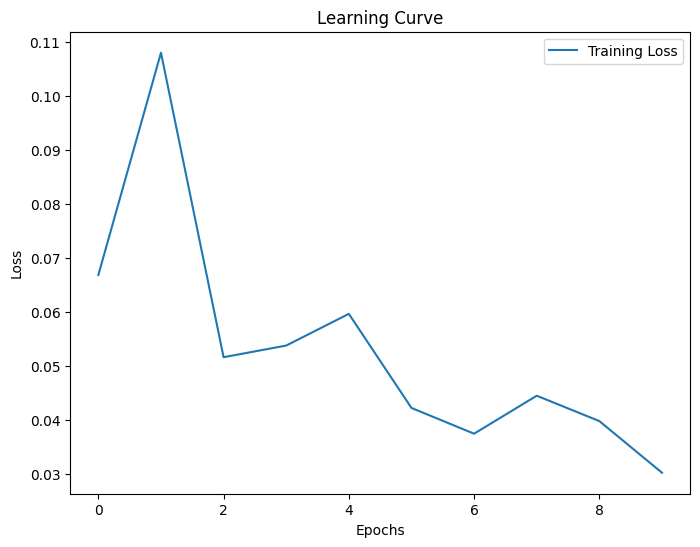

In [94]:
# ============================================================
# Training (unknown data)
# ============================================================
history_B2 = model_B2.fit(
    unknown_sequences,
    scaled_unknown_y,
    epochs=10,
    batch_size=64,
)
plot_learning_curve(history_B2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step
MSE: 85699749.49555975
MAE: 7090.901231516412
R2: -1.2200385181152855
MPL: 3545.450615758206


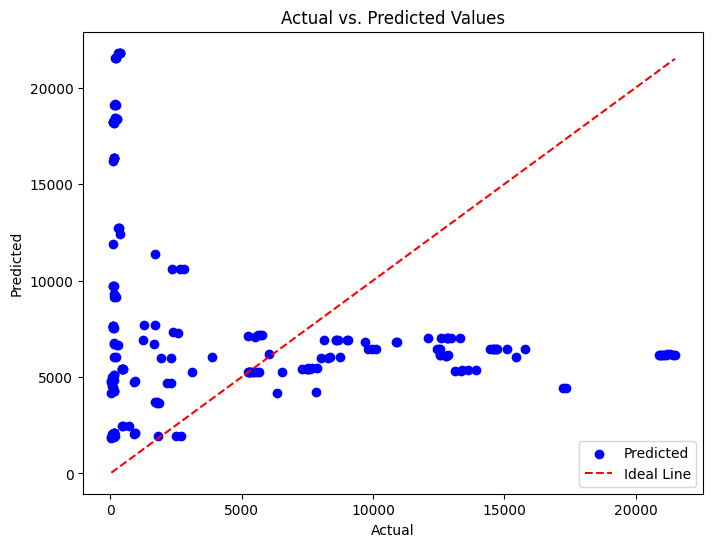

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
MSE: 67539719.11278696
MAE: 5814.590886762212
R2: 0.6197582235332358
MPL: 2907.295443381106


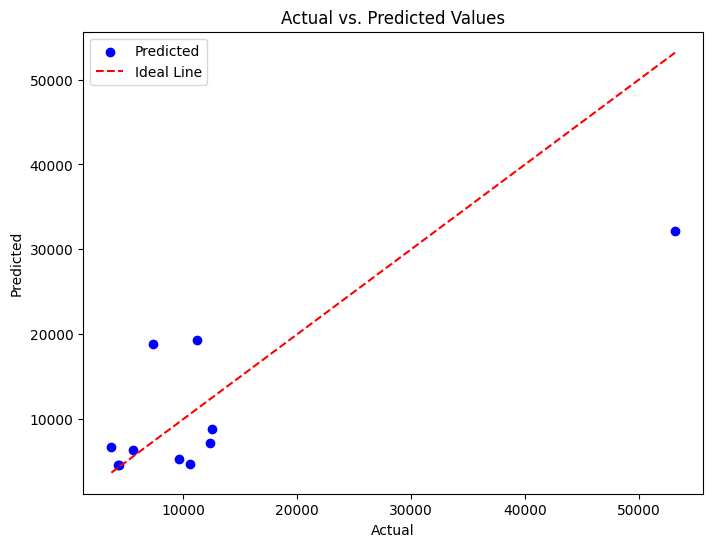

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step
MSE: 277261099.5658817
MAE: 11665.247989872043
R2: -4.735605117107775
MPL: 5832.6239949360215


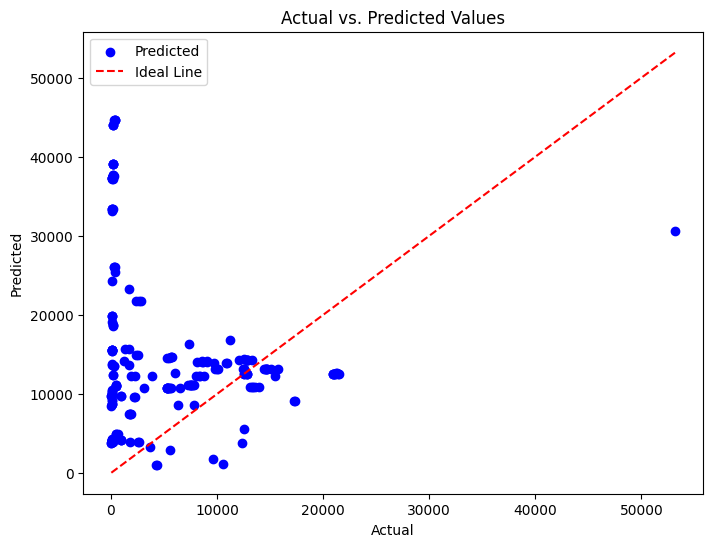

In [95]:
# ============================================================
# Evaluation (Block 2)
# NOTE:
# Block 2 expects token IDs produced by `unknown_processor.tokenizer`.
# Therefore, test data must be re-tokenized under the unknown tokenizer.
# ============================================================

# Re-tokenize test data for Block 2 inference (unknown tokenizer)
test_sequences_B2 = np.array(
    test_processor.pad_tokenize_sequences(
        tokenizer=unknown_processor.tokenizer,
        sequences=test_processor.data[DATA_COLUMN],
        max_seq_len=unknown_processor.max_seq_len,
    )
)

# Evaluate
predict_data(model_B2, test_sequences_B2, test_processor.targets, scaler_y)
predict_data(model_B2, unknown_sequences, unknown_processor.targets, scaler_unknown_y)

merged_sequences_B2 = np.concatenate((test_sequences_B2, unknown_sequences), axis=0)
predict_data(model_B2, merged_sequences_B2, merged_targets, scaler_merged_y)

In [96]:
# ============================================================
# Progressive Neural Network
# Block 3 (Merged Data)
# ============================================================
# NOTE:
# Block 3 is trained on merged data (test + unknown). Since it uses the
# tokenizer/vocabulary defined for the unknown-extended setting, all inputs
# must be tokenized with `unknown_processor.tokenizer`.

loss_B3 = "mse"
optimizer_B3 = optimizers.Adam(learning_rate=0.001)

metrics_list_B3 = [
    metrics.MeanAbsoluteError(),
    metrics.MeanAbsolutePercentageError(),
    metrics.RootMeanSquaredError(),
    metrics.MeanSquaredLogarithmicError(),
]

In [97]:
# ============================================================
# Embedding initialisation (extend pretrained embedding from Block 1)
# ============================================================
pretrained_embedding_B3 = embedding_layer_B1.get_weights()[0]

temp_embeddings = np.random.uniform(
    -0.1,
    0.1,
    size=(unknown_processor.stats["num_words"], unknown_processor.stats["embedding_dim"]),
)

for old_idx in range(min(data_processor.stats["num_words"], unknown_processor.stats["num_words"])):
    temp_embeddings[old_idx] = pretrained_embedding_B3[old_idx]

embedding_layer_B3 = layers.Embedding(
    input_dim=unknown_processor.stats["num_words"],
    output_dim=unknown_processor.stats["embedding_dim"],
    trainable=True,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.Constant(temp_embeddings),
    name="embedding_layer_B3",
)

In [98]:
# ============================================================
# Model definition
# ============================================================
inp_seq_B3 = layers.Input(
    shape=(unknown_processor.max_seq_len,),
    name="input_sequence_B3",  # fixed name
)

# Use the embedding layer defined for B3 (fixed)
x_B3 = embedding_layer_B3(inp_seq_B3)

x_B3 = shared_module_1(x_B3)

# --- Optional regularisation (disabled) ---
# x_B3 = layers.BatchNormalization(name="shared_batch_norm_B3_1")(x_B3)
# x_B3 = layers.Dropout(0.2, name="shared_dropout_B3_1")(x_B3)

x_B3 = shared_module_2(x_B3)

# --- Optional: extra RNN / regularisation (disabled) ---
# x_B3 = layers.SimpleRNN(int(unknown_processor.stats["embedding_dim"]), return_sequences=True, name="rnn_B3_1")(x_B3)
# x_B3 = layers.BatchNormalization(name="batch_norm_B3_1")(x_B3)
# x_B3 = layers.Dropout(0.2, name="dropout_B3_1")(x_B3)

x_B3 = shared_module_3(x_B3)

# --- Optional regularisation (disabled) ---
# x_B3 = layers.BatchNormalization(name="shared_batch_norm_B3_2")(x_B3)
# x_B3 = layers.Dropout(0.2, name="shared_dropout_B3_2")(x_B3)

x_B3 = layers.GlobalAveragePooling1D(name="global_average_pooling_B3")(x_B3)

x_B3 = layers.Dense(int(unknown_processor.stats["embedding_dim"]), activation="relu", name="dense_B3_1")(x_B3)
x_B3 = layers.Dense(int(unknown_processor.stats["embedding_dim"]), activation="relu", name="dense_B3_2")(x_B3)

out_B3 = layers.Dense(1, activation=out_act_fn, name="output_B3")(x_B3)

model_B3 = Model(inputs=inp_seq_B3, outputs=out_B3, name="model_B3")
model_B3.compile(loss=loss_B3, optimizer=optimizer_B3, metrics=metrics_list_B3)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0333 - mean_absolute_error: 0.1378 - mean_absolute_percentage_error: 242377.7656 - mean_squared_logarithmic_error: 0.0154 - root_mean_squared_error: 0.1819 - val_loss: 0.0182 - val_mean_absolute_error: 0.1252 - val_mean_absolute_percentage_error: 8503.1992 - val_mean_squared_logarithmic_error: 0.0137 - val_root_mean_squared_error: 0.1349
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0202 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 247964.1094 - mean_squared_logarithmic_error: 0.0145 - root_mean_squared_error: 0.1421 - val_loss: 0.0065 - val_mean_absolute_error: 0.0578 - val_mean_absolute_percentage_error: 3029.5532 - val_mean_squared_logarithmic_error: 0.0039 - val_root_mean_squared_error: 0.0806
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0103 - mean_absolute_error: 0.0701 - mean_absolute_percentage_error: 103051.6016 - mean_squared_logarithmic_error: 0.0046 - root_mean_squared_error:

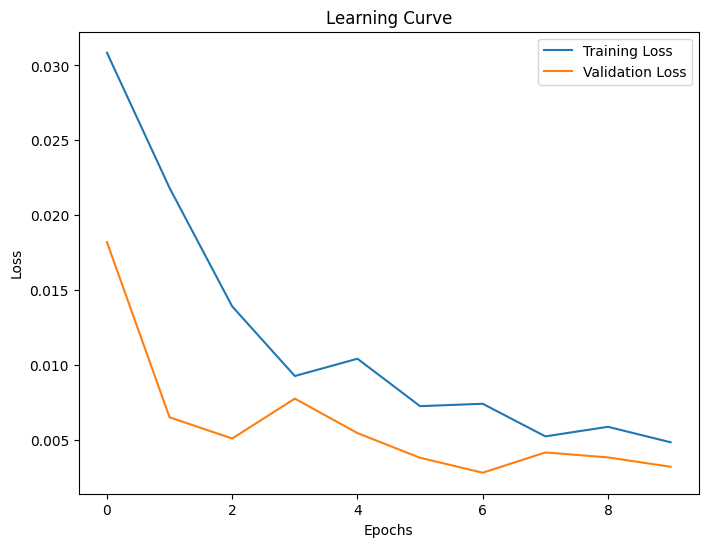

In [101]:
# ============================================================
# Train/val split on merged data (tokenized with unknown tokenizer)
# ============================================================
# Use the merged sequences that are compatible with the unknown tokenizer.
# If you followed Block 2 refactor, this is `merged_sequences_B2`.
merged_sequences_for_B3 = merged_sequences_B2  # alias for clarity

merged_train_X, merged_val_X, merged_train_y, merged_val_y = train_test_split(
    merged_sequences_for_B3,
    scaled_merged_y,
    test_size=0.2,
    random_state=SEED,
)

history_B3 = model_B3.fit(
    merged_train_X,
    merged_train_y,
    epochs=10,
    batch_size=64,
    validation_data=(merged_val_X, merged_val_y),
)
plot_learning_curve(history_B3)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step
MSE: 20211138.00701088
MAE: 2825.2087744321925
R2: 0.4764336519696277
MPL: 1412.6043872160963


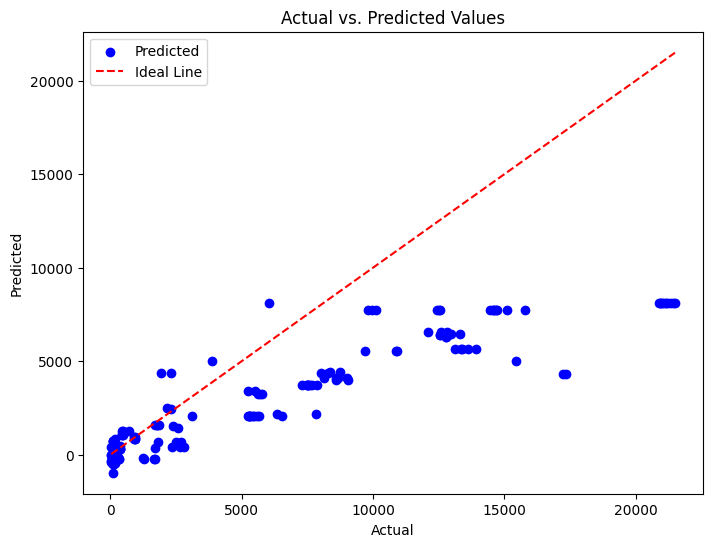

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
MSE: 138161240.00702533
MAE: 7709.04341825065
R2: 0.22216621524006086
MPL: 3854.521709125325


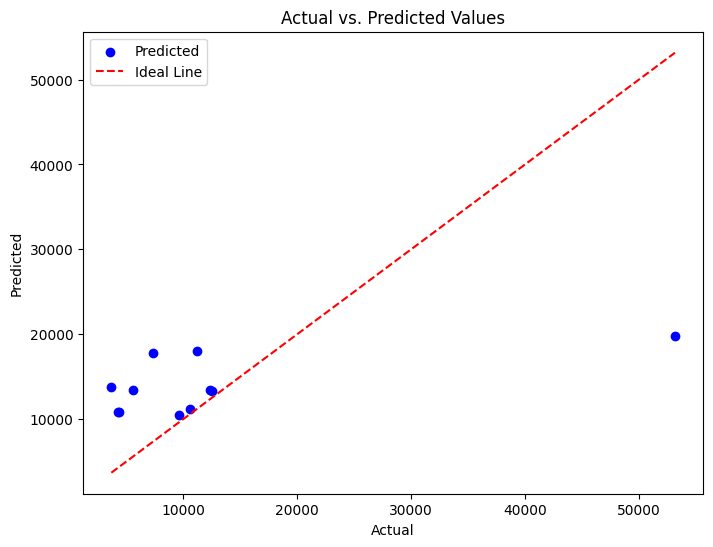

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step
MSE: 11581785.559043506
MAE: 1697.1323234053398
R2: 0.7604115809188359
MPL: 848.5661617026699


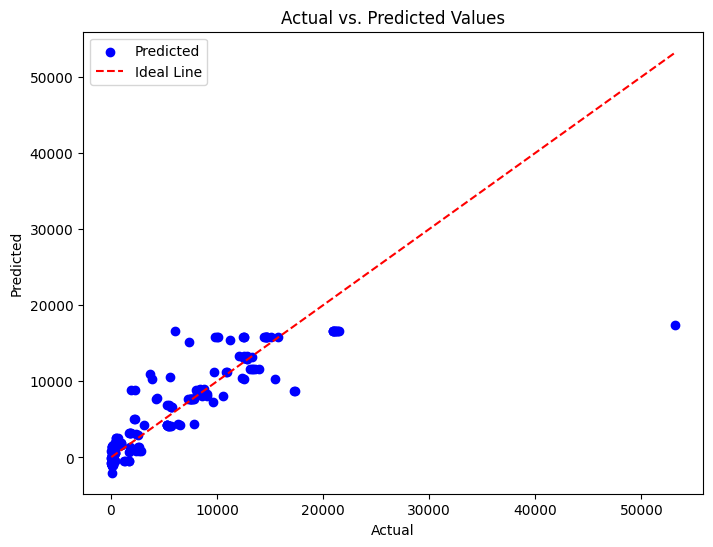

In [102]:
# ============================================================
# Evaluation (Block 3)
# ============================================================
# Block 3 expects unknown-tokenizer sequences, so use the B2-compatible test/merged.
predict_data(model_B3, test_sequences_B2, test_processor.targets, scaler_y)
predict_data(model_B3, unknown_sequences, unknown_processor.targets, scaler_unknown_y)
predict_data(model_B3, merged_sequences_for_B3, merged_targets, scaler_merged_y)